In [1]:
import matplotlib.pyplot as plt

from utils import data_loader
from utils import model

import os
import sys
import pathlib

import numpy as np

from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import expand_labels
from scipy.ndimage import gaussian_filter
from skimage import measure

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


ROOT_PATH = str(pathlib.Path().absolute())
DATA_STORAGE_PATH = '/data_storage/'
STORAGE_PATH = ROOT_PATH + DATA_STORAGE_PATH

DATASET_PATH = '/datasets/final_data'
FINAL_DATASET_PATH = ROOT_PATH + DATASET_PATH

TRAIN_PATH_IMAGES = FINAL_DATASET_PATH + '/train/images/'
TEST_PATH_IMAGES = FINAL_DATASET_PATH + '/test/images/'
VALI_PATH_IMAGES = FINAL_DATASET_PATH + '/validation/images/'

TRAIN_PATH_MASKS = FINAL_DATASET_PATH + '/train/masks/'
TEST_PATH_MASKS = FINAL_DATASET_PATH + '/test/masks/'
VALI_PATH_MASKS = FINAL_DATASET_PATH + '/validation/masks/'

2022-08-23 03:44:14.092473: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/home/lbbduy/anaconda3/envs/master_python/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-08-23 03:44:14.863984: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-23 03:44:14.864503: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-23 03:44:14.892139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 03:44:14.892536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:172

In [2]:
model_pretrained = model.load_pretrained_model('./model_checkpoints/model_unet_checkpoint_08_21_2022_041653.h5')

2022-08-23 03:44:17.166002: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-23 03:44:17.166174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 03:44:17.166570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-23 03:44:17.166612: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-23 03:44:17.166630: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-23 03:44:17.166637: I tensorflow/stream_executor/plat

In [36]:
image = imread('./examples/Image3681.jpg')[:, :, :3]
resize_shape = image.shape

In [37]:
mask = model.predict(model_pretrained, image)
mask  = np.around(mask)
density_amount = np.sum(np.around(mask))

In [38]:
density_amount

38.0

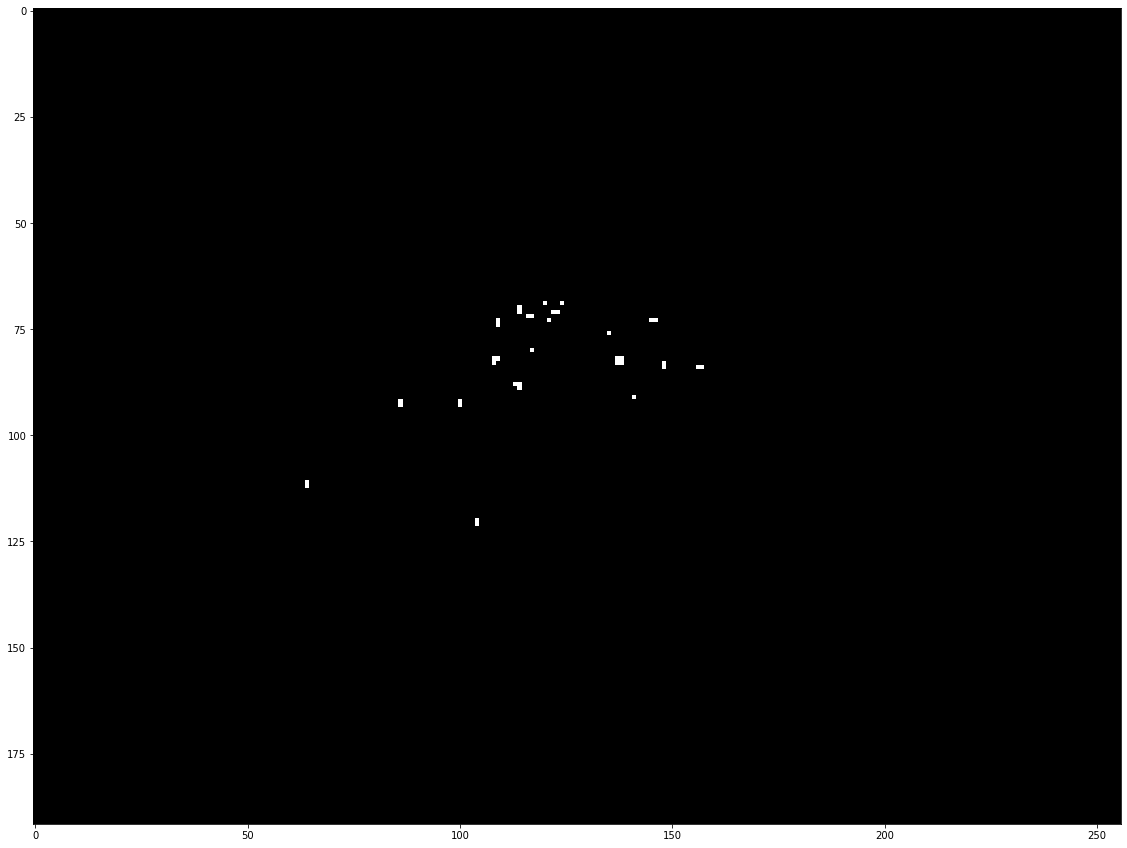

In [39]:
plt.figure(figsize=(30, 15))
plt.imshow(mask, cmap='gray')
plt.show()

In [40]:
image = resize(image, resize_shape, mode='constant', preserve_range=True).astype(np.uint8)

In [41]:
from utils.heat_map import HeatMap

In [42]:
mask.shape

(192, 256, 1)

In [43]:
mask = mask.reshape((192, 256))
hm = HeatMap(image, mask, gaussian_std=density_amount / 2)

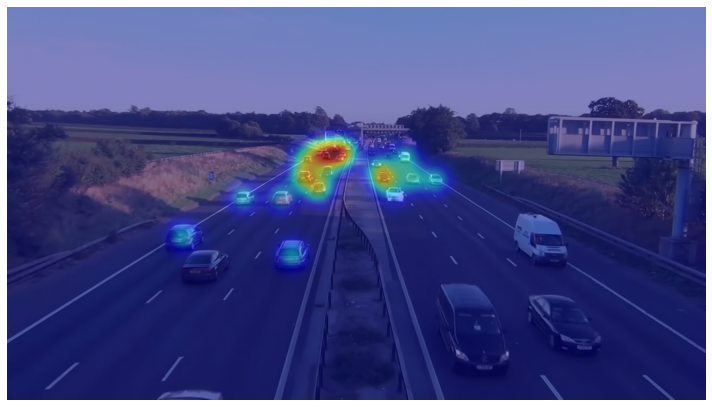

In [44]:
hm.plot(transparency=0.5,color_map='jet')